In [62]:
!pip install matplotlib

In [63]:
!pip install numpy

In [64]:
!pip install PyWavelets

In [65]:
!pip install filterpy

#Generating a Signal

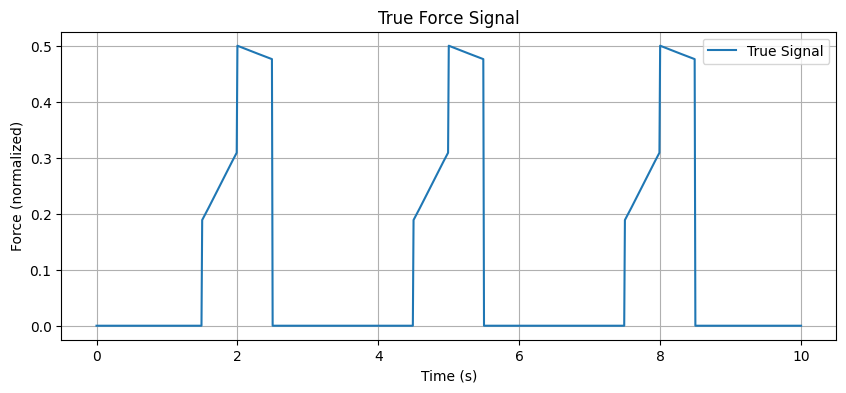

In [66]:
import math
import matplotlib.pyplot as plt

# Parameters for synthetic signal generation
fs = 100            # Sampling rate in Hz
duration = 10       # Duration in seconds
N_samples = int(fs * duration) + 1  # Number of samples
dt = 1 / fs         # Time step
t = [i * dt for i in range(N_samples)]  # Time vector

# Grasp parameters for stroke patient
A = 0.5             # Peak force (reduced for stroke patient)
k = 2               # Steepness of rise (slower for stroke)
decay_rate = 0.1    # Decay rate for sustain phase
t_start_list = [1.5, 4.5, 7.5]  # Start times of grasps
t_rise = 0.5        # Rise time in seconds
grasp_duration = 1.0  # Total grasp duration in seconds

# Generate true signal: sum of three grasp attempts
def logistic_rise(t, t_start, A, k, t_rise):
    """Logistic function for the rise phase of the grasp."""
    return A / (1 + math.exp(-k * (t - t_start - t_rise / 2)))

def exponential_decay(t, t_start, A, decay_rate, t_rise):
    """Exponential decay for the sustain phase of the grasp."""
    return A * math.exp(-decay_rate * (t - t_start - t_rise))

f = [0] * N_samples
for t_start in t_start_list:
    for i, ti in enumerate(t):
        if t_start <= ti < t_start + t_rise:
            f[i] += logistic_rise(ti, t_start, A, k, t_rise)
        elif t_start + t_rise <= ti < t_start + grasp_duration:
            f[i] += exponential_decay(ti, t_start, A, decay_rate, t_rise)

# Plot the true signal
plt.figure(figsize=(10, 4))
plt.plot(t, f, label='True Signal')
plt.legend()
plt.title('True Force Signal')
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.grid(True)
plt.show()

#Generating Noise and Superimposing it on the Force Readings

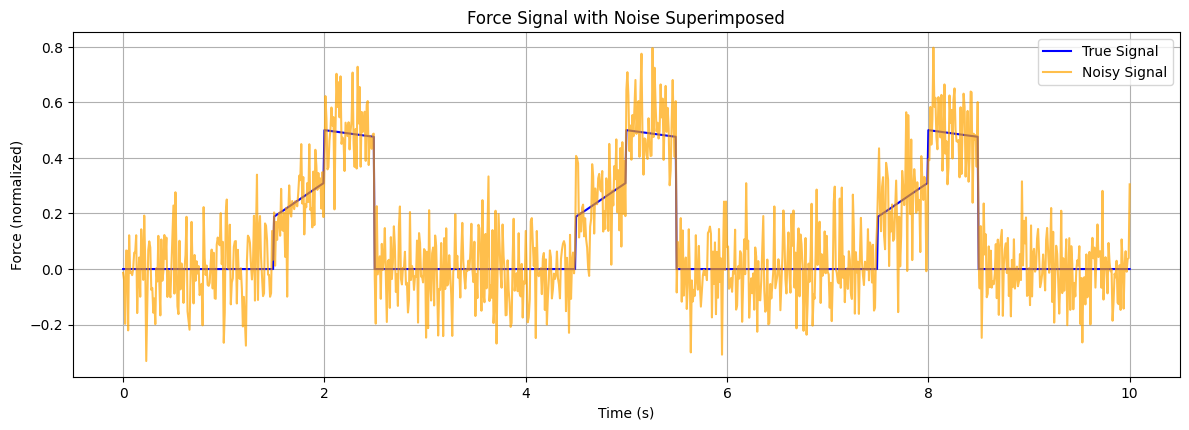

In [67]:
import random
import matplotlib.pyplot as plt

# Assume 'f', 't', and 'N_samples' are available from Snippet 1
# If running independently, you'd need to copy the signal generation code here

# Generate noise
random.seed(0)      # For reproducibility
hand_noise = [random.gauss(0, 0.05) for _ in range(N_samples)]  # Low-frequency variability
sensor_noise = [random.gauss(0, 0.1) for _ in range(N_samples)]  # High-frequency sensor noise
noise = [hand_noise[i] + sensor_noise[i] for i in range(N_samples)]

# Noisy signal: true signal + noise
y = [f[i] + noise[i] for i in range(N_samples)]

# Create a figure with two subplots
plt.figure(figsize=(12, 8))

# Plot: True Signal with Noise Superimposed (True Signal and Noisy Signal)
plt.subplot(2, 1, 2)
plt.plot(t, f, label='True Signal', color='blue')
plt.plot(t, y, label='Noisy Signal', color='orange', alpha=0.7)  # Slightly transparent to see overlap
plt.legend()
plt.title('Force Signal with Noise Superimposed')
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#Applying Kalman Filtering

MSE Kalman Filter: 0.0051


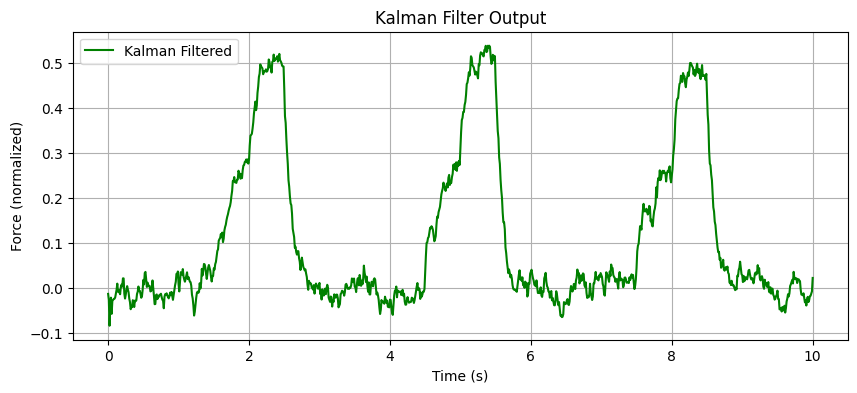

In [68]:
import matplotlib.pyplot as plt

# Assume 'y', 'f', 't', and 'N_samples' are available from previous snippets

# Kalman Filter Function
def kalman_filter(y, Q, R, x0, P0):
    """Apply a Kalman filter with process noise Q and measurement noise R."""
    len_y = len(y)
    x_hat = [0] * len_y
    P = [0] * len_y
    x_hat_minus = x0
    P_minus = P0

    for k in range(len_y):
        # Kalman gain
        K = P_minus / (P_minus + R)
        # Update estimate with measurement
        x_hat[k] = x_hat_minus + K * (y[k] - x_hat_minus)
        # Update error covariance
        P[k] = (1 - K) * P_minus
        # Predict next step
        x_hat_minus = x_hat[k]
        P_minus = P[k] + Q

    return x_hat

# Kalman filter parameters
Q = 0.0001  # Process noise variance
R = 0.01    # Measurement noise variance
x0 = 0      # Initial state estimate
P0 = 1      # Initial error covariance
y_kf = kalman_filter(y, Q, R, x0, P0)

# Compute Mean Squared Error (MSE) for Kalman filter
MSE_kf = sum((y_kf[i] - f[i])**2 for i in range(N_samples)) / N_samples
print(f"MSE Kalman Filter: {MSE_kf:.4f}")

# Plot the Kalman filtered signal
plt.figure(figsize=(10, 4))
plt.plot(t, y_kf, label='Kalman Filtered', color='green')
plt.legend()
plt.title('Kalman Filter Output')
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.grid(True)
plt.show()

#Moving Average Filtering

MSE Moving Average: 0.0021


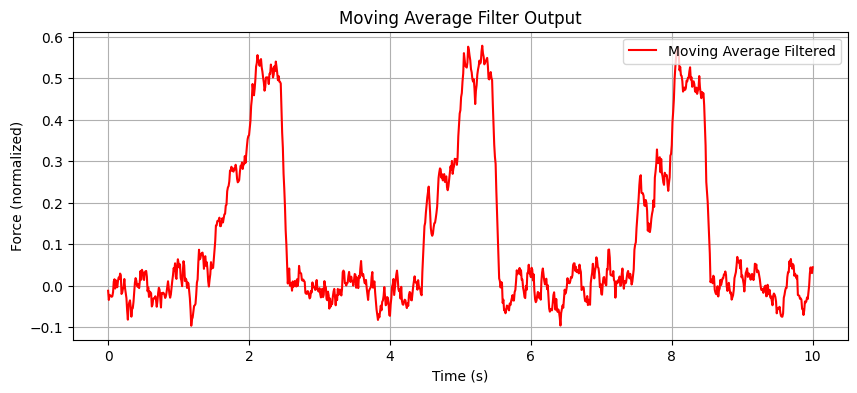

In [69]:
import matplotlib.pyplot as plt
import numpy as np
# Assume 'y', 'f', 't', and 'N_samples' are available from previous snippets

# Moving Average Filter Function
def moving_average(y, N):
    """Apply a moving average filter with window size N."""
    y_filtered = []
    for k in range(len(y)):
        if k < N:
            avg = sum(y[:k+1]) / (k + 1)
        else:
            avg = sum(y[k - N + 1:k + 1]) / N
        y_filtered.append(avg)
    return y_filtered

window_size = 10  # Number of samples to average
y_ma = np.convolve(y, np.ones(window_size)/window_size, mode='same')

# Compute Mean Squared Error (MSE) for moving average filter
MSE_ma = sum((y_ma[i] - f[i])**2 for i in range(N_samples)) / N_samples
print(f"MSE Moving Average: {MSE_ma:.4f}")

# Plot the moving average filtered signal
plt.figure(figsize=(10, 4))
plt.plot(t, y_ma, label='Moving Average Filtered', color='red')
plt.legend()
plt.title('Moving Average Filter Output')
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.grid(True)
plt.show()

#Low Pass Filter


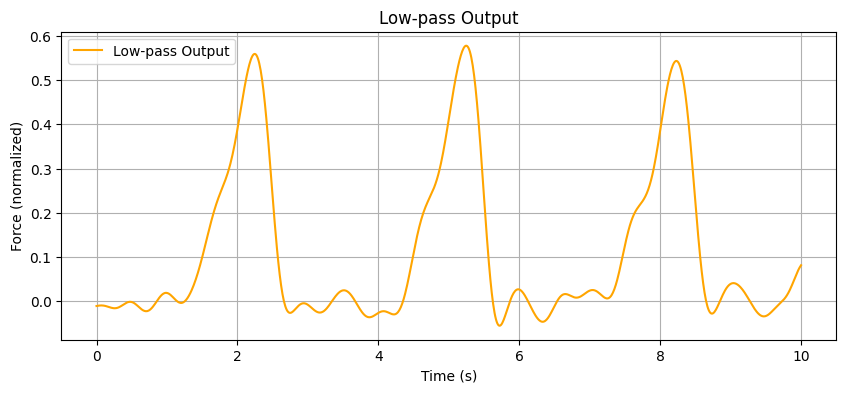

In [70]:
from scipy.signal import butter, filtfilt

# Assume 'y' is the noisy signal and 'fs' is the sampling frequency (e.g., 100 Hz)
cutoff = 2.0  # Cutoff frequency in Hz
order = 4     # Filter order
b, a = butter(order, cutoff / (fs / 2), btype='low')  # Design filter
y_filtered = filtfilt(b, a, y)  # Apply filter with zero-phase shift


plt.figure(figsize=(10, 4))
plt.plot(t, y_filtered, label='Low-pass Output', color='orange')
plt.legend()
plt.title('Low-pass Output')
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.grid(True)
plt.show()

#Comparing all the models


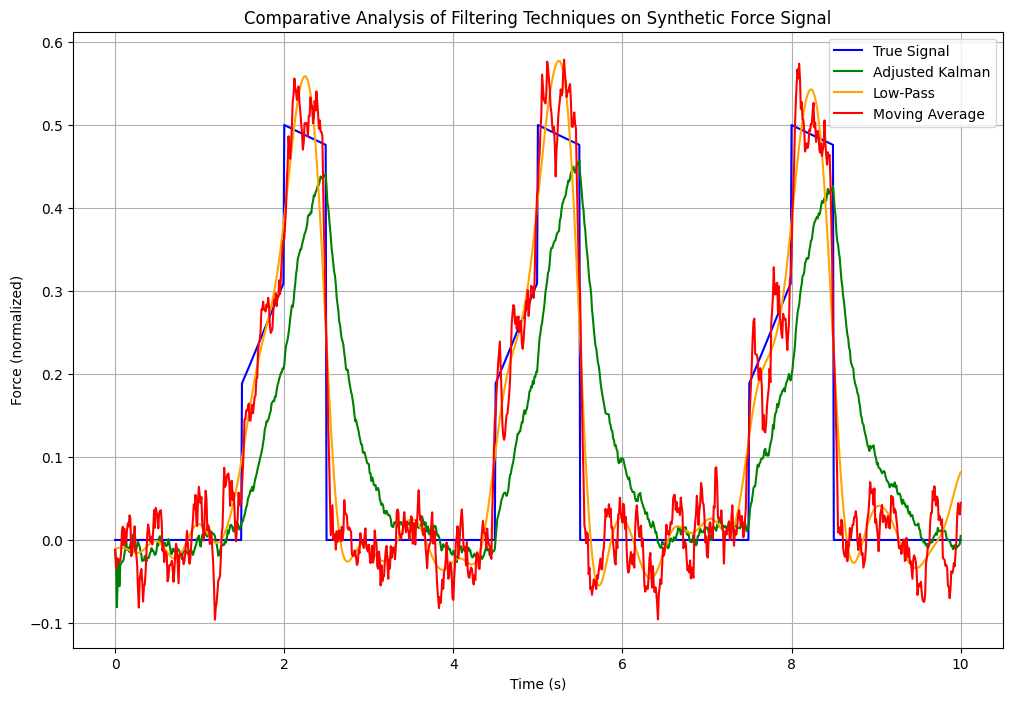

In [71]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Parameters for synthetic signal generation
fs = 100            # Sampling rate in Hz
duration = 10       # Duration in seconds
N_samples = int(fs * duration) + 1  # Number of samples
dt = 1 / fs         # Time step
t = [i * dt for i in range(N_samples)]  # Time vector

# Grasp parameters for stroke patient
A = 0.5             # Peak force (reduced for stroke patient)
k = 2               # Steepness of rise (slower for stroke)
decay_rate = 0.1    # Decay rate for sustain phase
t_start_list = [1.5, 4.5, 7.5]  # Start times of grasps
t_rise = 0.5        # Rise time in seconds
grasp_duration = 1.0  # Total grasp duration in seconds

# Generate true signal: sum of three grasp attempts
def logistic_rise(t, t_start, A, k, t_rise):
    """Logistic function for the rise phase of the grasp."""
    return A / (1 + math.exp(-k * (t - t_start - t_rise / 2)))

def exponential_decay(t, t_start, A, decay_rate, t_rise):
    """Exponential decay for the sustain phase of the grasp."""
    return A * math.exp(-decay_rate * (t - t_start - t_rise))

f = [0] * N_samples
for t_start in t_start_list:
    for i, ti in enumerate(t):
        if t_start <= ti < t_start + t_rise:
            f[i] += logistic_rise(ti, t_start, A, k, t_rise)
        elif t_start + t_rise <= ti < t_start + grasp_duration:
            f[i] += exponential_decay(ti, t_start, A, decay_rate, t_rise)

# Generate noise
random.seed(0)      # For reproducibility
hand_noise = [random.gauss(0, 0.05) for _ in range(N_samples)]  # Low-frequency variability
sensor_noise = [random.gauss(0, 0.1) for _ in range(N_samples)]  # High-frequency sensor noise
noise = [hand_noise[i] + sensor_noise[i] for i in range(N_samples)]

# Noisy signal: true signal + noise
y = [f[i] + noise[i] for i in range(N_samples)]

# Adjusted Kalman Filter
def adjusted_kalman_filter(y, Q=0.0001, R=0.1, x0=0, P0=1):
    """Apply an adjusted Kalman filter to the noisy signal."""
    len_y = len(y)
    x_hat = [0] * len_y
    P = [0] * len_y
    x_hat_minus = x0
    P_minus = P0

    for k in range(len_y):
        # Kalman gain
        K = P_minus / (P_minus + R)
        # Update estimate with measurement
        x_hat[k] = x_hat_minus + K * (y[k] - x_hat_minus)
        # Update error covariance
        P[k] = (1 - K) * P_minus
        # Predict next step
        x_hat_minus = x_hat[k]
        P_minus = P[k] + Q

    return x_hat

y_kalman = adjusted_kalman_filter(y, Q=0.0001, R=0.1)

# Low-Pass Filter
def low_pass_filter(y, cutoff=2.0, order=4):
    """Apply a Butterworth low-pass filter to the noisy signal."""
    b, a = butter(order, cutoff / (fs / 2), btype='low')
    y_filtered = filtfilt(b, a, y)
    return y_filtered

y_filtered = low_pass_filter(y)

# Moving Average Filter
def moving_average(y, window_size=10):
    """Apply a moving average filter to the noisy signal."""
    y_ma = np.convolve(y, np.ones(window_size)/window_size, mode='same')
    return y_ma

y_ma = moving_average(y)

# Plot all signals for comparison
plt.figure(figsize=(12, 8))
plt.plot(t, f, label='True Signal', color='blue')
plt.plot(t, y_kalman, label='Adjusted Kalman', color='green')
plt.plot(t, y_filtered, label='Low-Pass', color='orange')
plt.plot(t, y_ma, label='Moving Average', color='red')
plt.legend()
plt.title('Comparative Analysis of Filtering Techniques on Synthetic Force Signal')
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.grid(True)
plt.show()

#Experiment

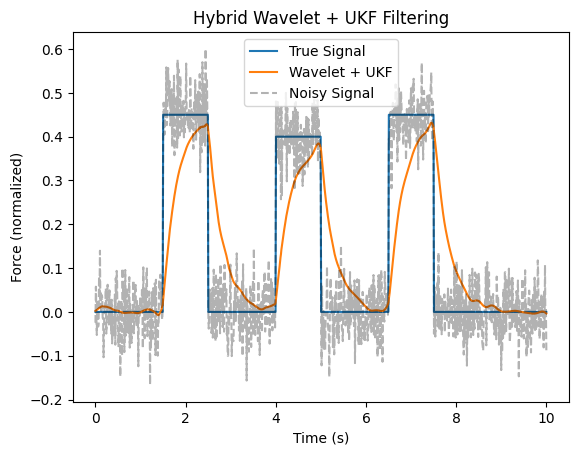

MSE: 0.0164


In [72]:
import numpy as np
import pywt
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
import matplotlib.pyplot as plt

# Synthetic data (approximating the graph)
t = np.linspace(0, 10, 1000)
f = np.concatenate([np.zeros(150), 0.45*np.ones(100), np.zeros(150), 0.4*np.ones(100), np.zeros(150), 0.45*np.ones(100), np.zeros(250)])
y = f + np.random.normal(0, 0.05, f.size)  # Noisy signal

# Step 1: Wavelet Denoising
coeffs = pywt.wavedec(y, 'db4', level=4)
threshold = 0.1
coeffs = [pywt.threshold(coeffs[i], threshold, 'soft') if i > 0 else coeffs[i] for i in range(len(coeffs))]
# Alternative: coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, 'soft') for c in coeffs[1:]]
y_wavelet = pywt.waverec(coeffs, 'db4')

# Step 2: UKF
def fx(x, dt): return x  # State transition (simple model)
def hx(x): return x      # Measurement function
points = MerweScaledSigmaPoints(1, alpha=0.1, beta=2., kappa=1.)
ukf = UnscentedKalmanFilter(dim_x=1, dim_z=1, dt=0.01, fx=fx, hx=hx, points=points)
ukf.x = np.array([0.])   # Initial state
ukf.P = 1.0              # Initial covariance
ukf.Q = 0.0001           # Process noise
ukf.R = 0.1              # Measurement noise
y_ukf = []
for z in y_wavelet:
    ukf.predict()
    ukf.update([z])
    y_ukf.append(ukf.x[0])

# Plot
plt.plot(t, f, label='True Signal')
plt.plot(t, y_ukf, label='Wavelet + UKF')
plt.plot(t, y, 'k--', alpha=0.3, label='Noisy Signal')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force (normalized)')
plt.title('Hybrid Wavelet + UKF Filtering')
plt.show()

# Calculate MSE
mse = np.mean((np.array(y_ukf) - f)**2)
print(f"MSE: {mse:.4f}")